In [1]:
import skimage
import skimage.feature
# from skimage.color import rgb2gray
# from skimage.transform import resize, rescale
import pytesseract
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pytesseract import image_to_string
from utils import hed_util
import os

# Name of the directory containing the object detection module we're using
MODEL_NAME = 'model'
HED_NAME = 'HED'
# Grab path to current working directory
CWD_PATH = os.getcwd()
HED_PROTOTEXT_PATH = os.path.join(CWD_PATH,MODEL_NAME,HED_NAME,'deploy.prototxt')
HED_CAFFEE_MODEL_PATH = os.path.join(CWD_PATH,MODEL_NAME,HED_NAME,'hed_pretrained_bsds.caffemodel')
net = hed_util.load_dnn(HED_PROTOTEXT_PATH,HED_CAFFEE_MODEL_PATH)
TEST_IMAGE_PATH = os.path.join(CWD_PATH, 'test_images')

In [8]:
def listToString(s):
    str = ""
    for element in s:
        str += element
        str += " "
    return str

# Edge & Boarder Detection
def edge_detection(image,resize_scale, sigma, l_thresh, h_thresh):
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    resized = cv2.resize(gray,(image.shape[1]//resize_scale,image.shape[0]//resize_scale))
    blur = cv2.blur(resized,(5,5))
#     blur = cv2.fastNlMeansDenoising(resized, None, 3, 7, 21)
    thresh = cv2.threshold(blur, 100, 255, cv2.THRESH_BINARY)[1]
    edges = skimage.feature.canny(
    image=thresh/255,
    sigma=sigma,
    low_threshold=l_thresh,
    high_threshold=h_thresh,
    )
    return blur, edges


def border_detection(blur,edges):
    x = [i for i in range(edges.shape[0]) if np.count_nonzero(edges[i] == True, axis = 0)>0]
    y = [i for i in range(edges.shape[1]) if np.count_nonzero(edges[:,i] == True, axis = 0)>0]
    if ((len(x)>0)and(len(y)>0)):
        blur = blur[max(0,min(x)-10):max(x),max(0,min(y)-10):max(y)]
    return blur

## ocr mykad
## extract NRIC and DOB
def extract_nric(image):
    nric = image[75:200,0:400]

    s = image_to_string(nric, config = 'digits')

    idx = s.find('-')
    # first apply on gray image
    if (idx == 6):
        id_num = s
        dob = s[0:2] + '-' + s[2:4] + '-' + s[4:6]
        return id_num, dob
    else:
        for i in range(80,130,10):
            nric_thresh = cv2.threshold(nric, i, 255, cv2.THRESH_BINARY)[1]
            s1 = image_to_string(nric_thresh, config = 'digits')
            idx1 = s1.find('-')
            if (idx1==6):
                id_num = s1
                dob = s1[0:2] + '-' + s1[2:4] + '-' + s1[4:6]
                return id_num, dob
            elif (idx1 > 6):
                dob = s1[idx1-6:idx1-4] + '-' + s1[idx1-4:idx1-2] + '-' + s1[idx1-2:idx1]
                id_num =s1[idx1-6:idx1+6]
                return id_num, dob
            elif (idx < idx1 < 6):
                s = s1
                idx = idx1


        id_num = s
        dob = s[:idx]
        return id_num, dob

## extract NAME
def extract_name(image):
    name = image[300:410,0:500]
    custom_config = r'--oem 3 --psm 6'
    t = image_to_string(name, config = custom_config, lang = 'eng+msa')
    print('name ', t)
    s = image_to_string(name, config = custom_config, lang = 'eng+msa').splitlines( )

    NAM = [item for item in s if ((item != '') and (item.find(' ') != -1) and (item==item.upper()))]

    for i in range(80,130,10):
        name_thresh = cv2.threshold(name, i, 255, cv2.THRESH_BINARY)[1]
        s_t = image_to_string(name_thresh, config = custom_config, lang = 'eng+msa').splitlines( )
        new_s_t = [item for item in s_t if ((item != '') and (item.find(' ') != -1) and (item==item.upper()))]
        if (len(new_s_t) > len(NAM)):
            NAM = new_s_t

    name_str = listToString(NAM)
    return name_str

## extract address
def extract_address(image):
    add = image[400: ,:500]
#     add = image[360: ,:500]
#     add_thresh = cv2.threshold(add, 90, 255, cv2.THRESH_BINARY)[1]
    custom_config = r'--oem 3 --psm 6'
    
    s = image_to_string(add, config = custom_config, lang = 'eng+msa').splitlines( )
    address = [item for item in s if ((item != '') and (item==item.upper()))]

    for i in range(80,130,10):
        add_thresh = cv2.threshold(add, i, 255, cv2.THRESH_BINARY)[1]
        s_t = image_to_string(add_thresh, config = custom_config, lang = 'eng+msa').splitlines( )
        new_s_t = [item for item in s_t if ((item != '') and (item==item.upper()))]
        if len(new_s_t) > len(address):
            address = new_s_t

    address_str = listToString(address)
    return address_str

## extract gender and nationality
def extract_gender(image):
    gender_im = image[440:,600:]
    gender = []
    custom_config = r'--oem 3 --psm 6'
    plt.imshow(gender_im)
    s = image_to_string(gender_im, config=custom_config, lang = 'eng+msa').splitlines( )
    print('gender ', s)
    for item in s:
        if (item.find('LEL') != -1):
            gender = 'M'
            return gender
        elif (item.find('PER') != -1):
            gender = 'F'
            return gender

    for i in range(80,130,10):
        gender_thresh = cv2.threshold(gender_im, i, 255, cv2.THRESH_BINARY)[1]
        s_t = image_to_string(gender_thresh, config=custom_config, lang = 'eng+msa').splitlines( )
        for item in s_t:
            if (item.find('LEL') != -1):
                gender = 'M'
                return gender
            elif (item.find('PER') != -1):
                gender = 'F'
                return gender

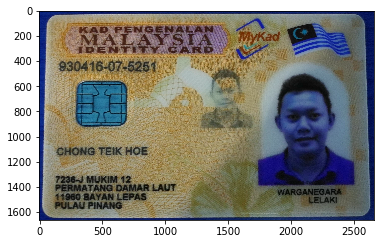

In [9]:
img_file = os.path.join(TEST_IMAGE_PATH,'cropped_000027.jpg')
image = cv2.imread(img_file)

plt.imshow(image)

name  CHONGTEIKHOE =
- Une ee a

gender  ['']
{'message': '200 (proper size)', 'nric': '930416-07-5251.\n\n.\n\x0c', 'dob': '93-04-16', 'name': 'CHONGTEIKHOE = ', 'address': 'PERMATANG DAMARLAUT = 44960 BAYAN LEPAS SS ', 'gender': None}


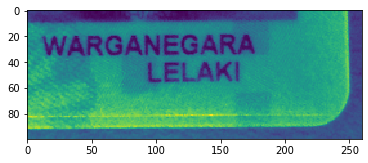

In [10]:
#860*540
data = {}
if image.shape[0]<800 or image.shape[1]<1000:
    data['message'] = '400 (image size is small)'

else:
    if image.shape[0]>=1500 and image.shape[1]>=2000:
        data['message'] = '200 (proper size)'
        #gray,edges = edge_detection(image, resize_scale=2, sigma=0, l_thresh=0, h_thresh=1)
        resize_scale=2
    else:
        data['message'] = '300 (mid size)'
        #gray,edges = edge_detection(image, resize_scale=1, sigma=0.5, l_thresh=0.1, h_thresh=0.4)
        resize_scale=1
        
    resized = cv2.resize(image,(image.shape[1]//resize_scale,image.shape[0]//resize_scale))
    cropped = hed_util.crop_image(net, resized)
    plt.imshow(resized)
    gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
    uint8 = cv2.resize(gray,(860,540),cv2.INTER_AREA)

    data['nric'], data['dob'] = extract_nric(uint8)
    NAME = extract_name(uint8)
    ADDRESS = extract_address(uint8)
    GENDER = extract_gender(uint8)
    data['name'] = NAME
    data['address'] = ADDRESS
    data['gender'] = GENDER
print(data)